In [ ]:
DATASET="rec.mu2e.CRV_wideband_cosmics.CRVWB-000-003-000-001ext.root"

In [ ]:
import time
import os
from mu2etools import *
from mu2etools import wideband

In [12]:
processor = wideband.DataProcessor(usexroot=True, fixtimes=True)
ar, arSpills = processor.getData(DATASET)

hep.style.use('ATLAS')  # or ATLAS/LHCb2

In [13]:
list_febID = ar['febID'].to_list()
FEBID = min(list_febID, key=lambda x: len(x))

NFEBS=len(FEBID)
print("Dataset: %s"%DATASET)
print("Number of FEBs: %d"%NFEBS)
print("List of FEBs: %s"%FEBID)

Dataset: rec.mu2e.CRV_wideband_cosmics.CRVWB-000-003-000-001ext.root
Number of FEBs: 2
List of FEBs: [25, 17]


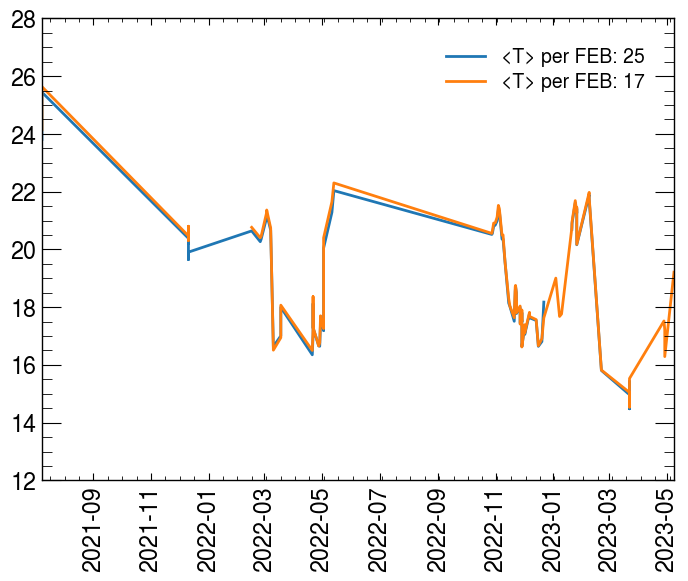

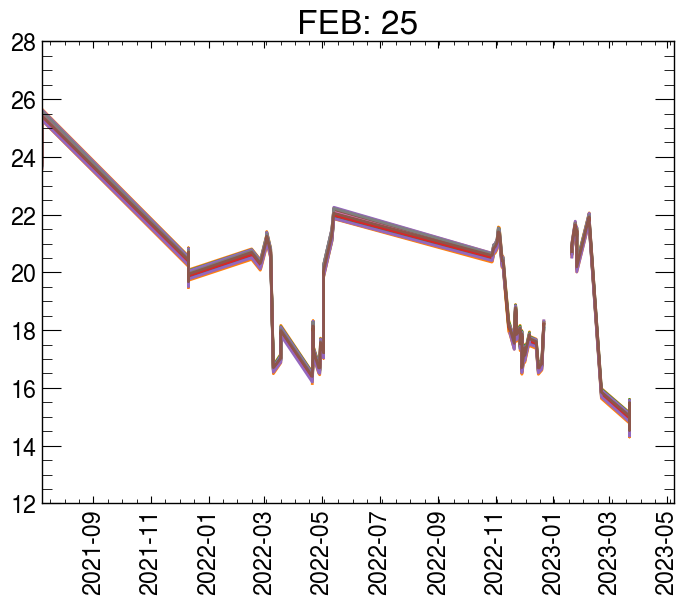

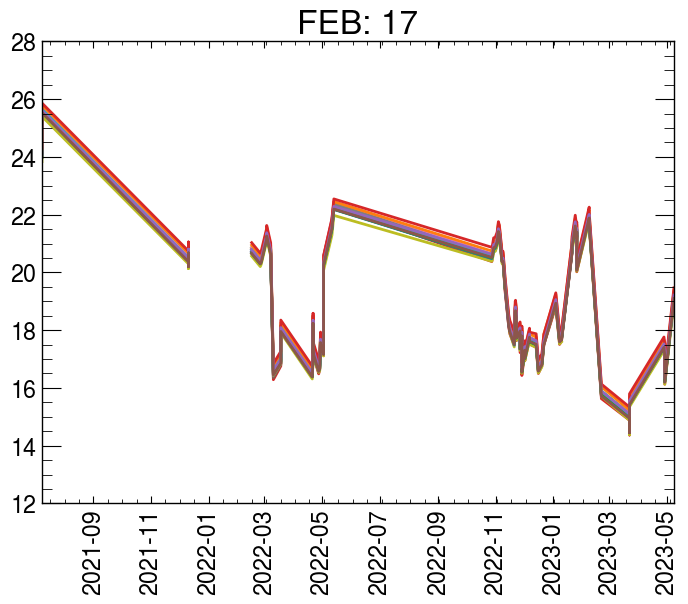

In [16]:
arTemp = ak.mask(ar['meanTemperatures'], (ar['stddevTemperatures']>0.001) & (ar['meanTemperatures']>0))

for idx, feb in enumerate(FEBID):
    x=ar['timestamp'].to_numpy().astype('datetime64[s]')
    y=ak.mean(arTemp[:,idx,::4], axis=1)
    
    plt.plot(x,y, '-', label='<T> per FEB: %d'%feb);
    plt.xticks(rotation=90)    

    plt.legend()
    
for idx, feb in enumerate(FEBID):
    x=ar['timestamp'].to_numpy().astype('datetime64[s]')
    y=arTemp[:,idx,::4]
    plt.figure()
    
    plt.plot(x,y, '-');
    plt.xticks(rotation=90)    

    plt.title("FEB: %d"%feb)

In [6]:
def getTree(file):
    retry_limit = 50
    retry_count = 0
    while retry_count < retry_limit:
        try:
            tree = uproot.open(file, xrootdsource={"timeout": 100})["run"]
            arr = tree.arrays(["temperature", "spillTimestamp"])
            time.sleep(5)
            break  # If no OSError occurs, break out of the loop
        except (OSError, RuntimeError) as e:
            print(f"Error occurred: {e}")
            retry_count += 1
            if retry_count < retry_limit:
                print("Retrying...")
                time.sleep(60)
            else:
                print("Retry limit reached. Exiting...")
    return arr

/pnfs/mu2e/tape/phy-rec/rec/mu2e/CRV_wideband_cosmics/CRVWB-000-003-000/root/2f/6e/rec.mu2e.CRV_wideband_cosmics.CRVWB-000-003-000.001159_000.root
/pnfs/mu2e/tape/phy-rec/rec/mu2e/CRV_wideband_cosmics/CRVWB-000-003-000/root/4f/90/rec.mu2e.CRV_wideband_cosmics.CRVWB-000-003-000.001177_000.root
/pnfs/mu2e/tape/phy-rec/rec/mu2e/CRV_wideband_cosmics/CRVWB-000-003-000/root/11/72/rec.mu2e.CRV_wideband_cosmics.CRVWB-000-003-000.001240_000.root
Error occurred: XRootD error: [ERROR] Operation expired
in file root://fndcadoor.fnal.gov/pnfs/fnal.gov/usr/mu2e/tape/phy-rec/rec/mu2e/CRV_wideband_cosmics/CRVWB-000-003-000/root/72/66/rec.mu2e.CRV_wideband_cosmics.CRVWB-000-003-000.001400_000.root
Retrying...
/pnfs/mu2e/tape/phy-rec/rec/mu2e/CRV_wideband_cosmics/CRVWB-000-003-000/root/22/28/rec.mu2e.CRV_wideband_cosmics.CRVWB-000-003-000.001407_002.root


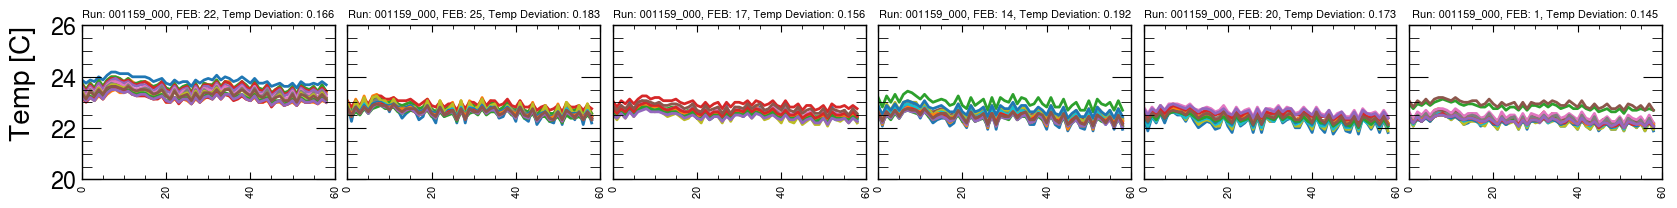

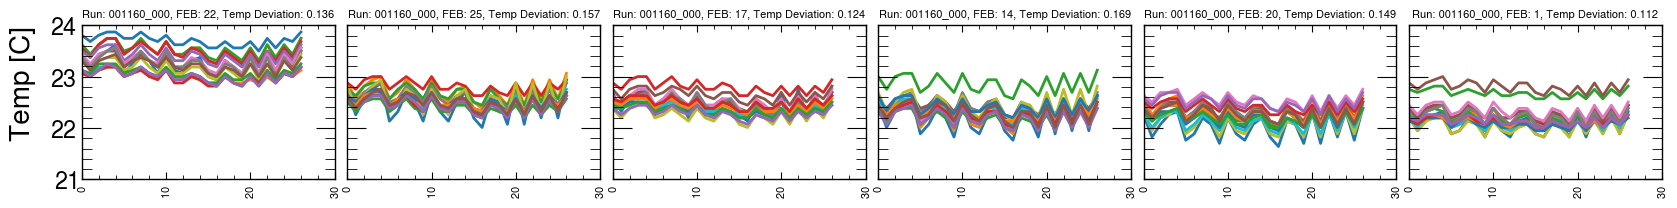

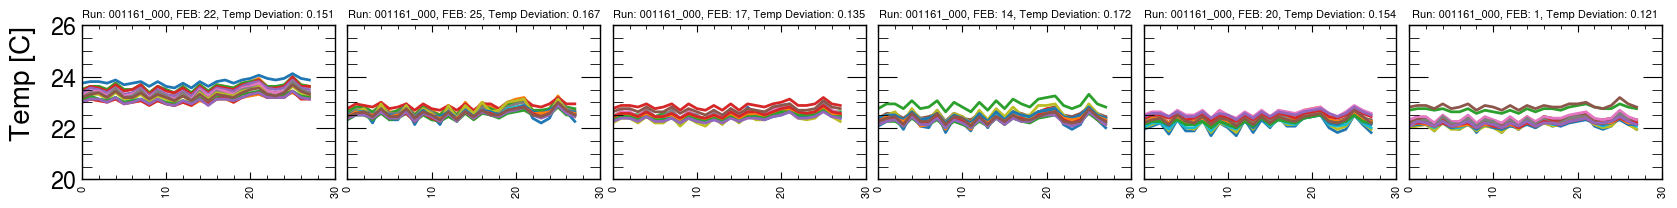

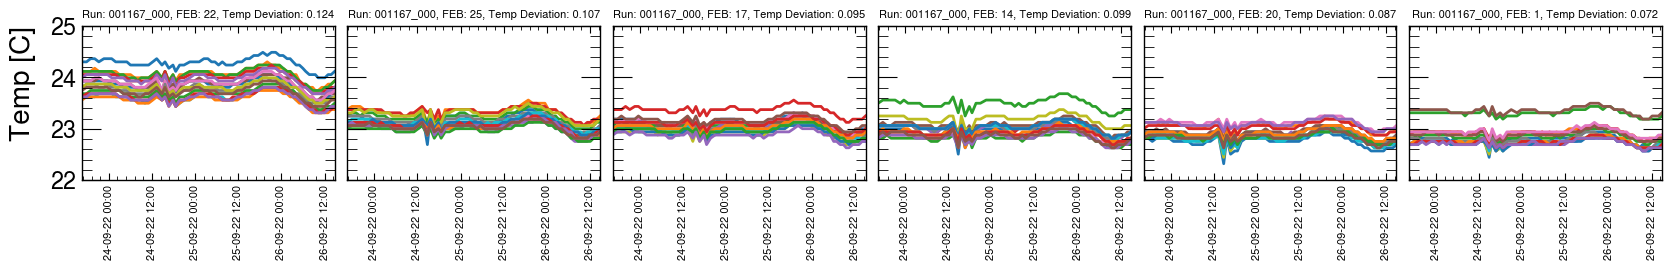

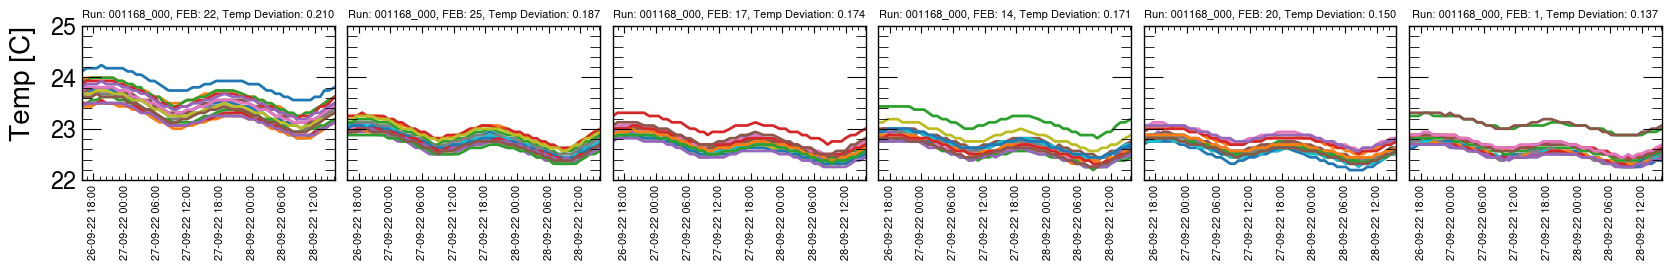

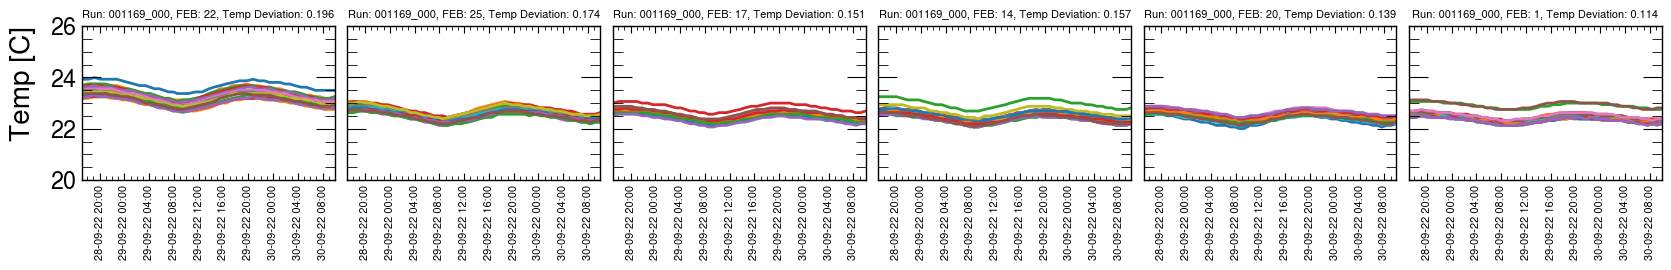

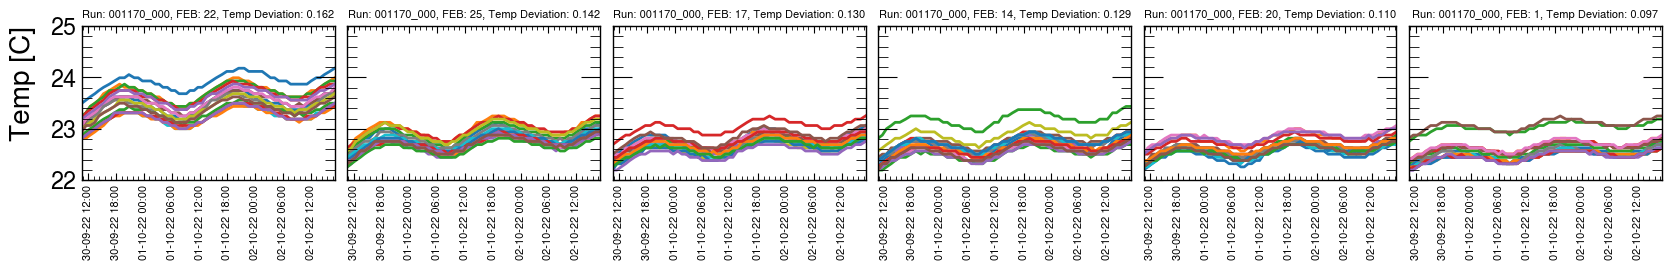

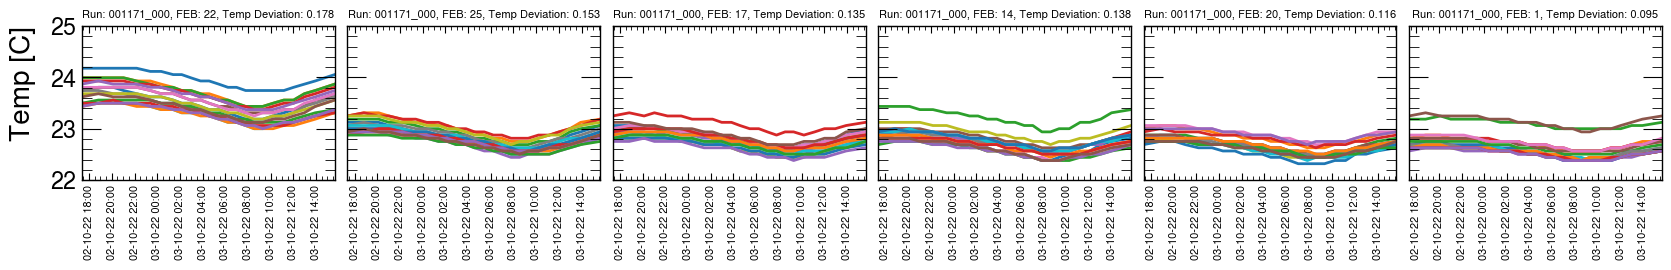

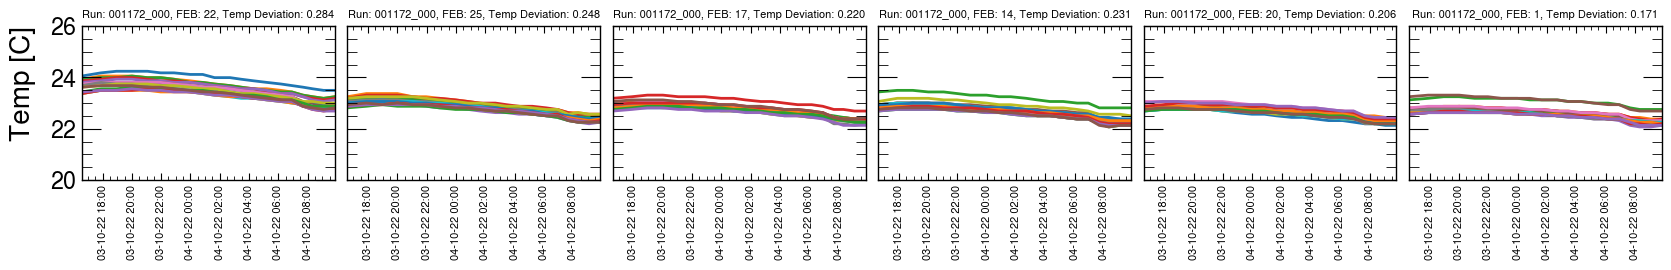

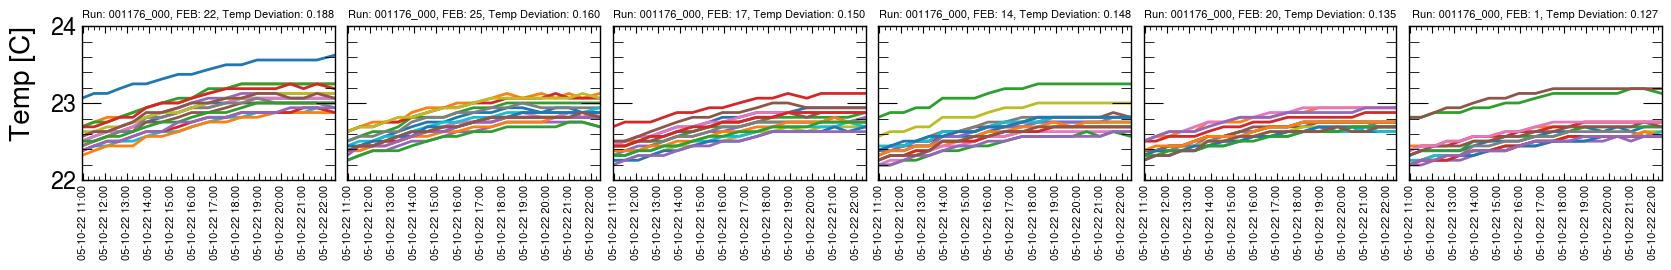

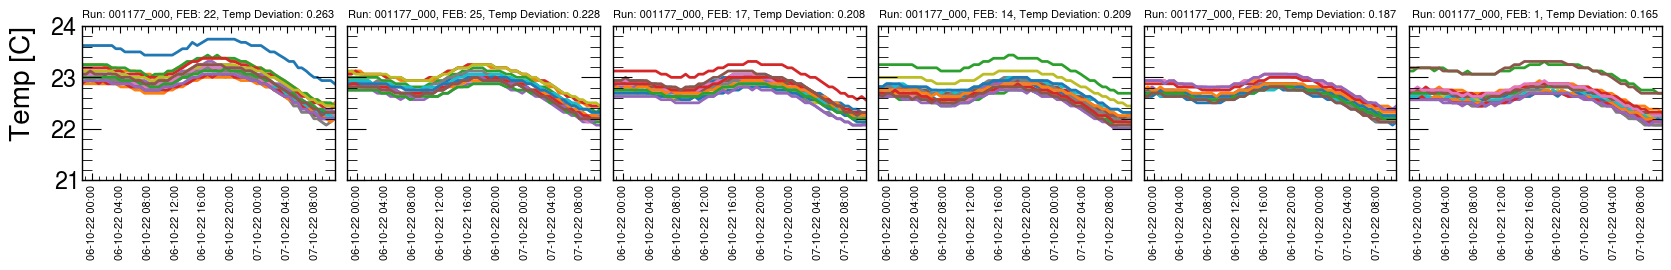

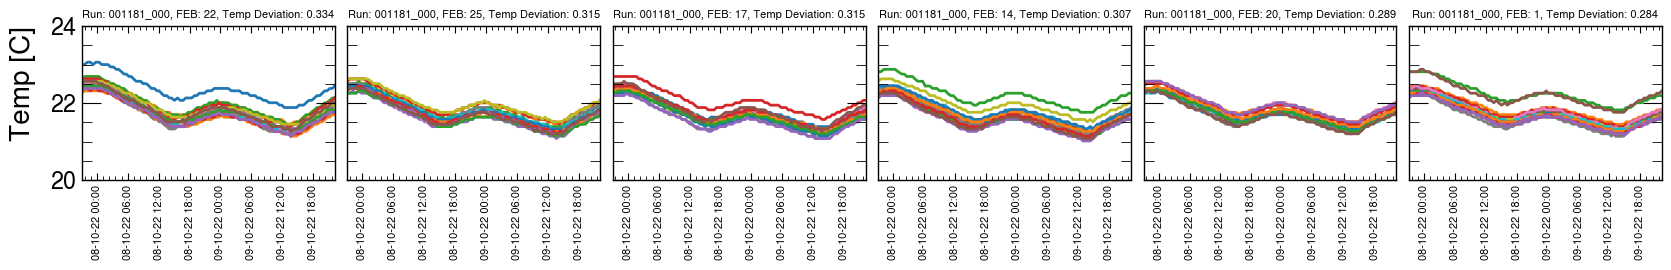

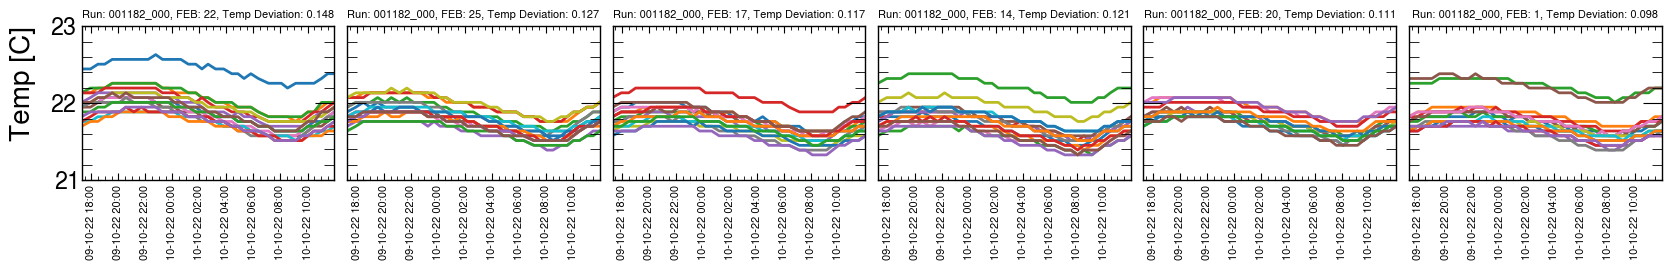

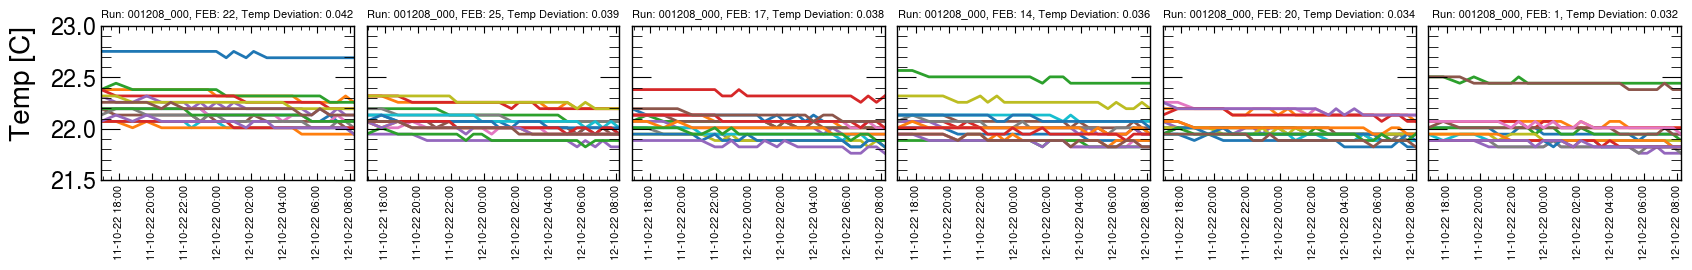

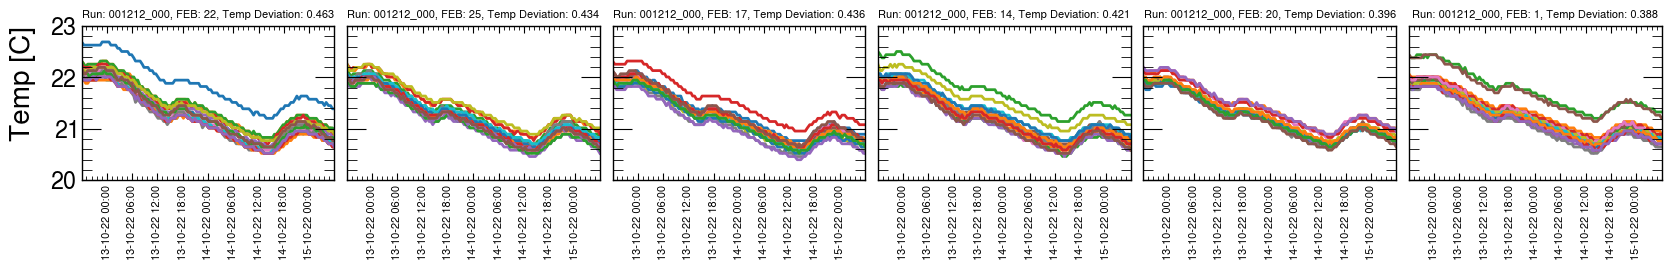

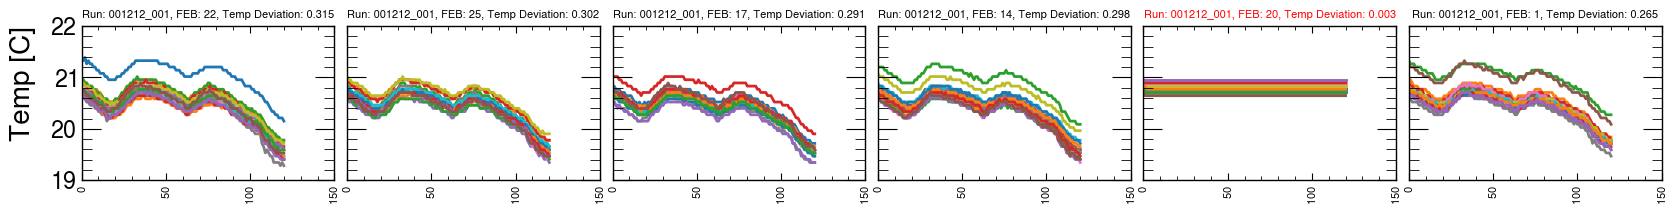

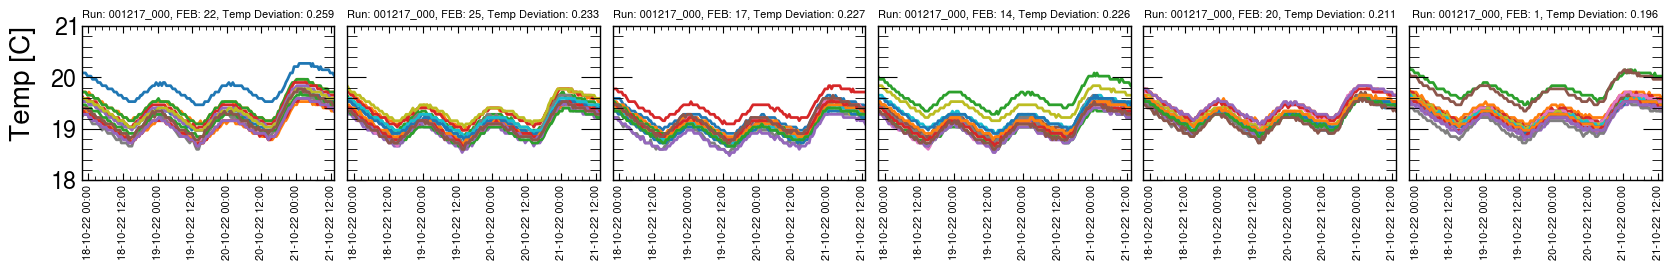

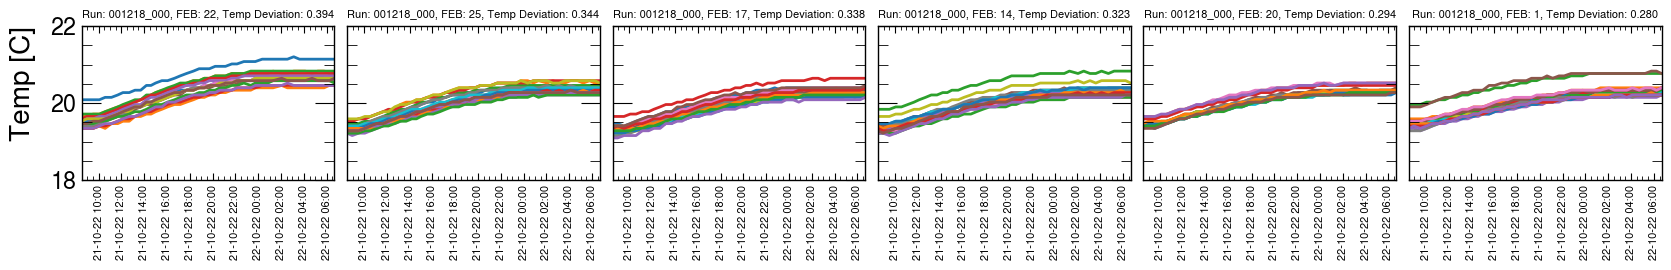

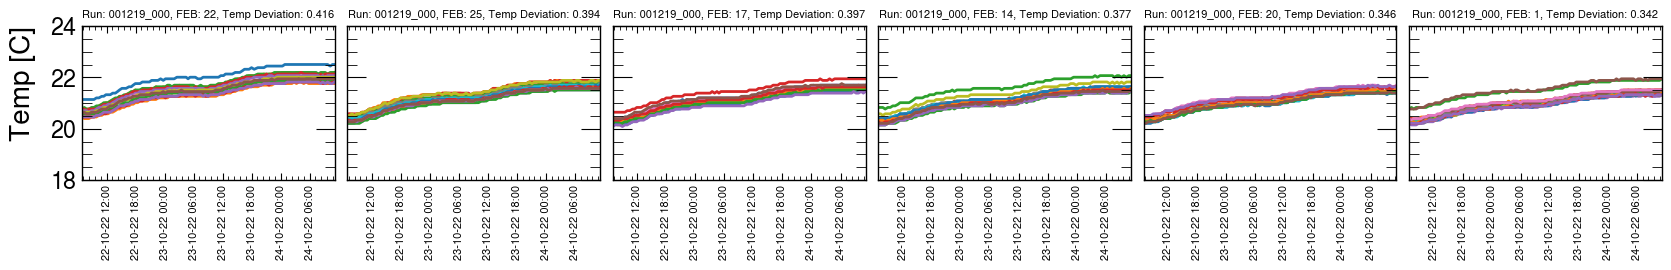

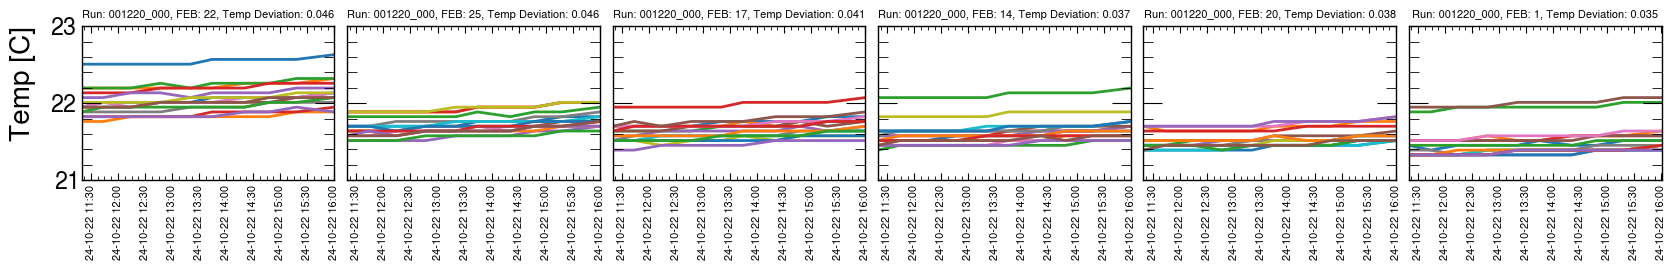

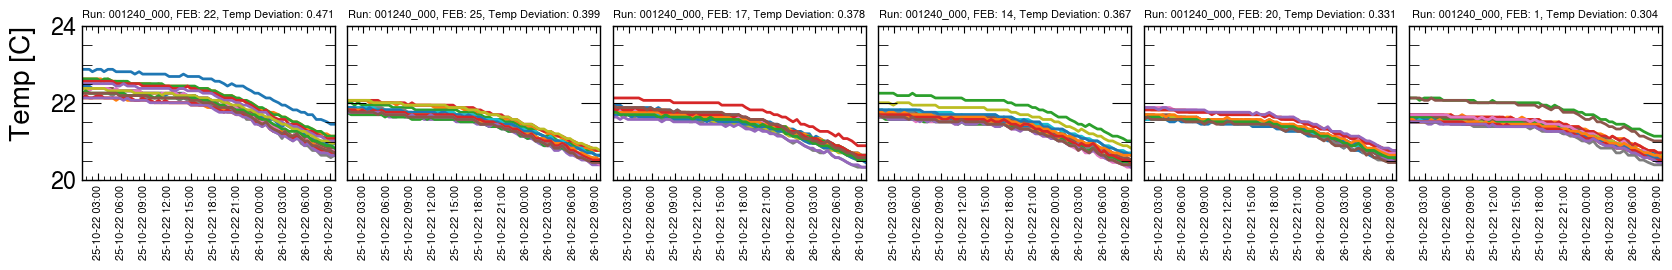

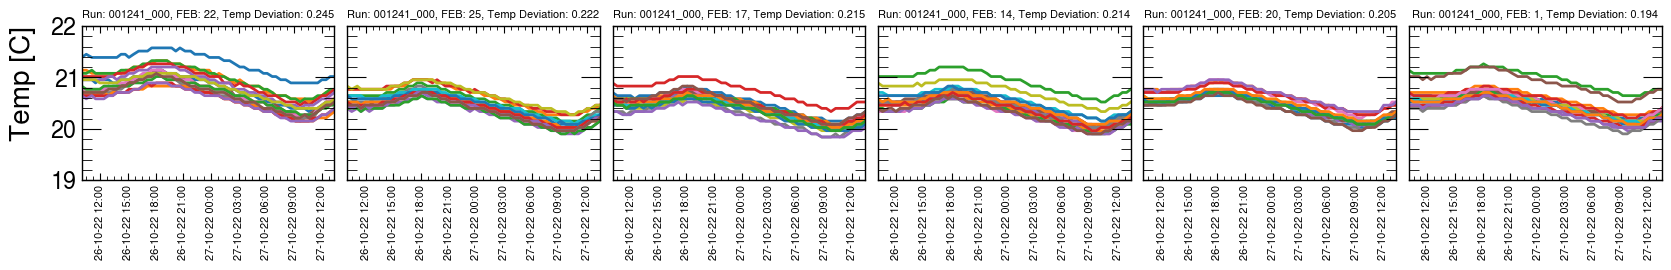

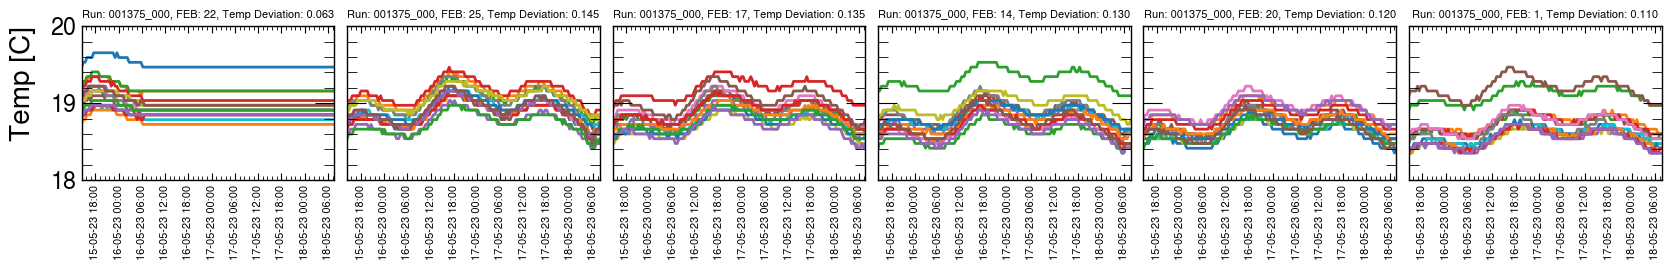

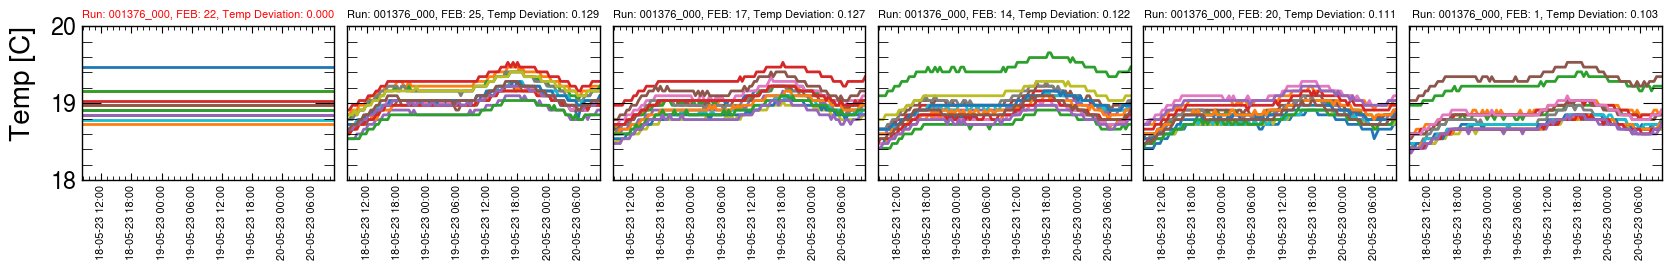

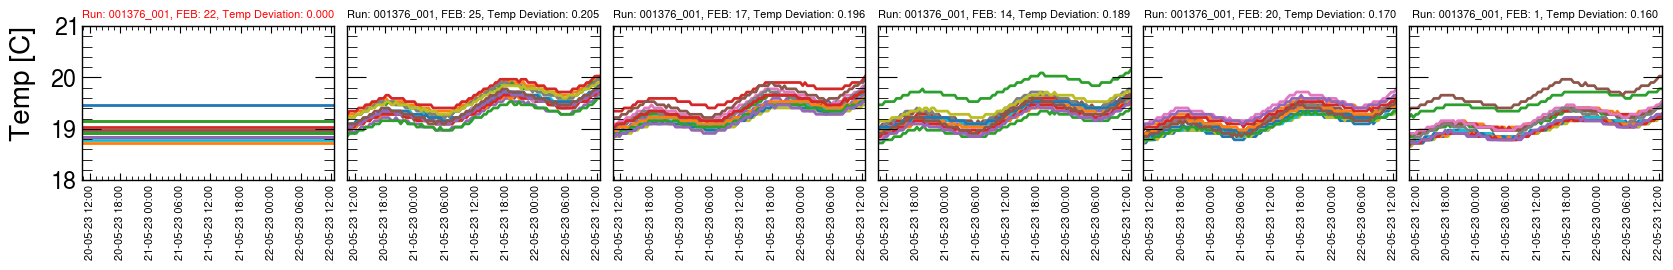

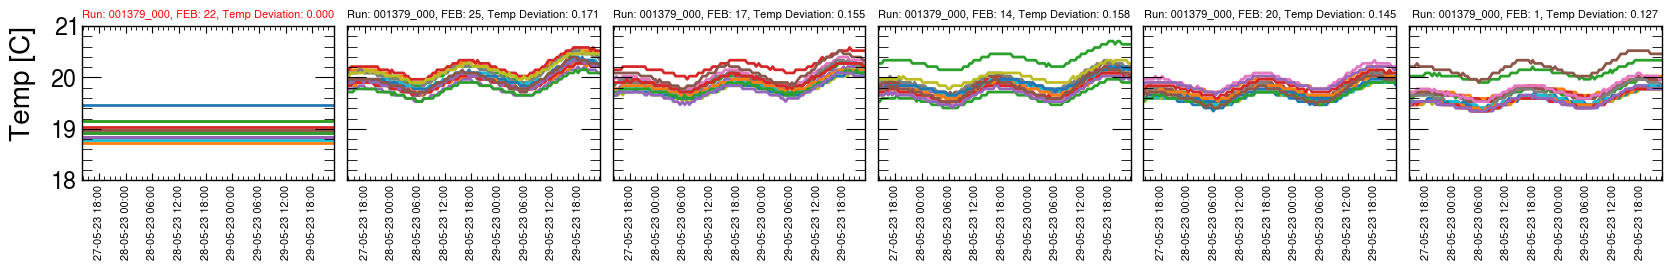

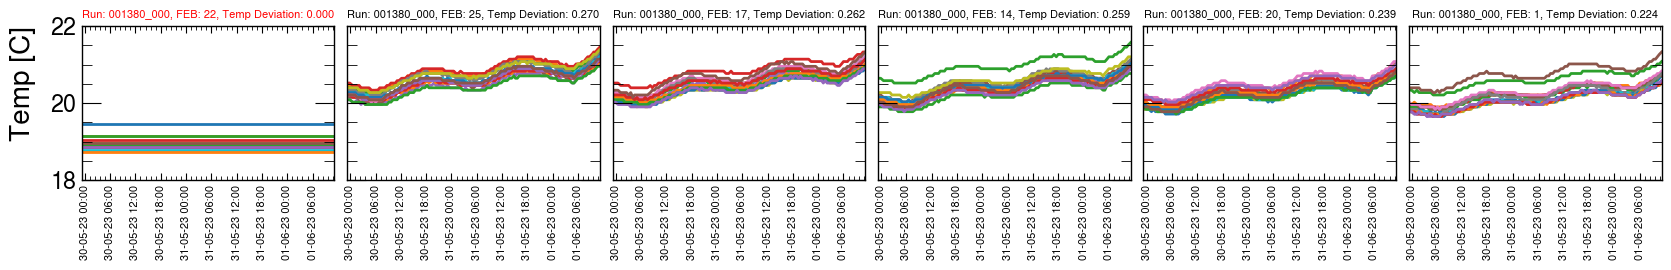

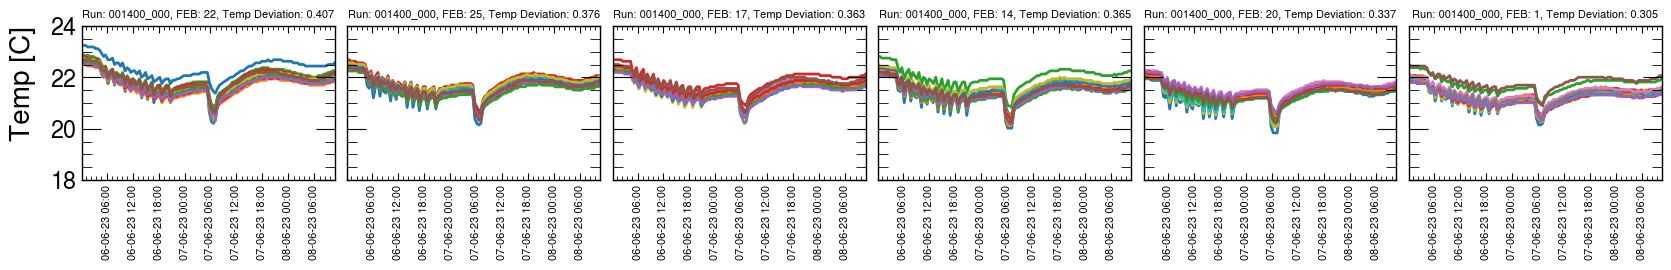

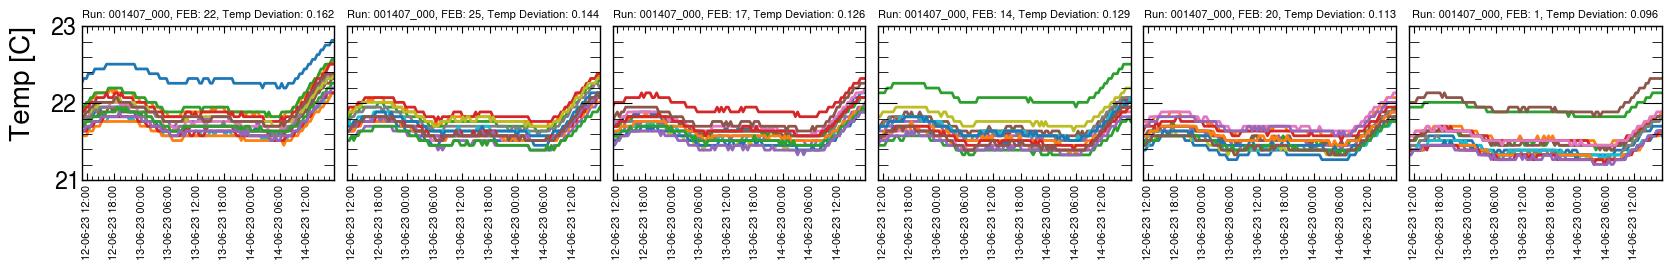

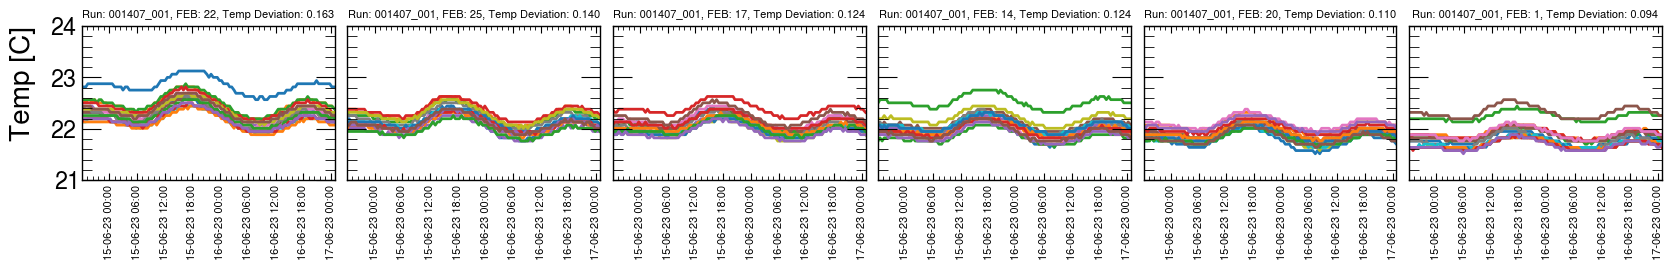

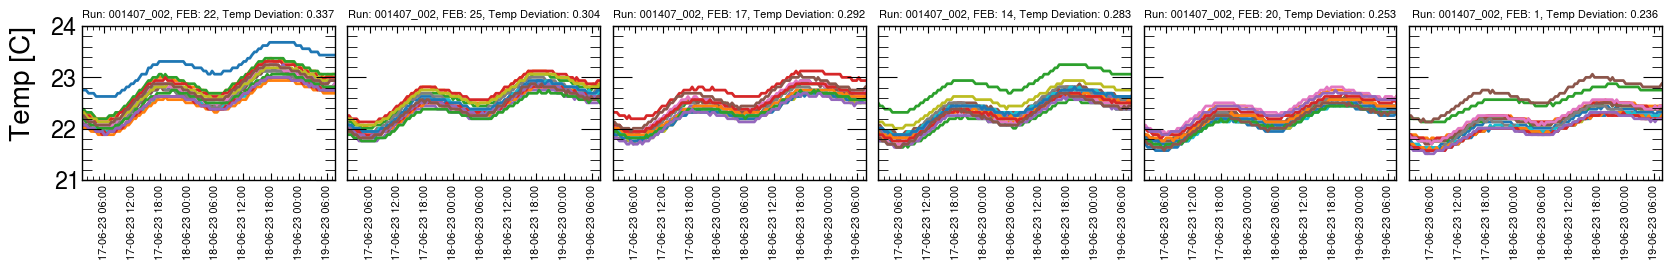

In [7]:
plt.rcParams.update({'figure.max_open_warning': 0})
import matplotlib.dates as mdates
sparsify=2000
epsilon=0.01
usexroot=True

for index, file in enumerate(processor.getFilelist(DATASET)):
    fig, ax1 = plt.subplots(nrows=1, ncols=NFEBS, figsize=(20, 2), sharey='row')
    plt.subplots_adjust(wspace=0.05)
    ax1[0].set_ylabel('Temp [C]')
    
    if index%10==0:
        print(file)

    if usexroot:
        file = 'root://fndcadoor.fnal.gov'+file[:5]+'/fnal.gov/usr/'+file[6:]
        
    for idx, feb in enumerate(FEBID):
        arr = getTree(file)
        # Read every "srapsify" entry, and every 4th CMB
        x=arr['spillTimestamp'][::sparsify].to_numpy()
        y=arr['temperature'][::sparsify,idx,::4].to_numpy()
        y = np.where(y < epsilon, np.nan, y) # Drop bad SPE points        
        #Plot with dates is the dates are present, otherwise use index
        if np.any(x == 0):
            ax1[idx].plot(y, '-')
        else: 
            ax1[idx].plot(x.astype('datetime64[s]'), y, '-')
            xfmt = mdates.DateFormatter('%d-%m-%y %H:%M')
            ax1[idx].xaxis.set_major_formatter(xfmt)

        # Add title
        y_std = y.astype(float).std(axis=0) # get an array of std for each cmb 
        y_std = np.nanmean(y_std) # get mean of all cmbs
        filename = os.path.basename(file)
        label_text ="Run: %s, FEB: %d, Temp Deviation: %.3f"%(filename.split('.')[-2], feb, y_std)
        ax1[idx].set_title(label_text, fontsize=8, color='black' if y_std > epsilon else 'red')        
        
        #Rotate x-axis labels
        ax1[idx].set_xticks(ax1[idx].get_xticks())
        ax1[idx].set_xticklabels(ax1[idx].get_xticklabels(), rotation=90, fontsize=8)


In [8]:
import datetime
current_time = datetime.datetime.now()
print("Current time:", current_time)

Current time: 2023-07-12 03:41:55.015364
